In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
import andreap
from scipy.interpolate import interp1d
import pickle

import importlib.util
import sys

In [2]:
test_index = 400
validation_set = False
# skips comparison with Andrea's code
fast = True

In [3]:
''' This messiness is necessary to import scripts which are not installed and
which are not located in the cwd.'''

spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../../cassL/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

spec = importlib.util.spec_from_file_location(
    "generate_emu_data", "../../../cassL/generate_emu_data.py")
ged = importlib.util.module_from_spec(spec)
sys.modules["generate_emu_data"] = ged
spec.loader.exec_module(ged)

In [4]:
hc = np.load("../hc_G3_redo.npy",
    allow_pickle=True)
samples = np.load("../samples_G3_redo.npy",
    allow_pickle=True)

if False:
    hc = np.load("../hc_backup_i4999_massive_pred_revised.npy",
        allow_pickle=True)
    samples = np.load("../samples_backup_i4999_massive_pred_revised.npy",
        allow_pickle=True)

if validation_set:
    hc = np.load("../hc_test_G3.npy",
        allow_pickle=True)
    samples = np.load("../samples_test_G3.npy",
        allow_pickle=True)
    
standard_k = np.load("../standard_k.npy", allow_pickle=True)

In [5]:
m = pickle.load(open("../analyses/massive_emulator_G3_full.nucomet", "rb"))

def inverse_transform(raw_prediction):
    return np.exp(raw_prediction * m.stdev + m.mu)

def nest(array):
    return np.array([np.array(array)])

In [6]:
test_cosmology = hc[test_index]
test_pspec = samples[test_index]

In [7]:
ombh2 = test_cosmology[0]
omch2 = test_cosmology[1]
ns = test_cosmology[2]
sigma12 = test_cosmology[3]
As = test_cosmology[4]
omnuh2 = test_cosmology[5]

In [8]:
full_cosm = ged.build_cosmology(ombh2, omch2, ns, sigma12, As, omnuh2)

In [9]:
mnu = full_cosm['mnu']

In [10]:
if not fast:
    Pk_lo_h = andreap.get_PK(ombh2, omch2, ns, mnu, 10, As)
    Pk_hi_h = andreap.get_PK(ombh2, omch2, ns, mnu, 67, As)
    Pk_target_h = andreap.get_PK(ombh2, omch2, ns, mnu, 57, As)

In [11]:
if not fast:
    z = np.linspace(0., 5., 500)
    sig12 = np.zeros(500)
    for i in range(500):
        sig12[i] = andreap.get_s12(Pk_hi_h['mzero'], z[i])

    sig12[0]
    
    sig12_interpolator = interp1d(sig12, z, kind='cubic')

In [12]:
sigma12

0.6828000072366219

In [13]:
g_pspec, g_sigma12, g_rescale = ged.evaluate_cell(full_cosm, standard_k)
print("This is our approximation", g_sigma12)

This is our approximation 0.6828000248192291


In [14]:
float(g_rescale[1])

1.2541721889850244

In [15]:
import copy as cp
tilde_cosm = cp.deepcopy(full_cosm)
tilde_cosm['omch2'] += tilde_cosm['omnuh2']
tilde_cosm = ci.specify_neutrino_mass(tilde_cosm, 0, 0)
ged.print_cosmology(tilde_cosm)
print()
ged.print_cosmology(full_cosm)

ombh2 0.020643445
omch2 0.157262
n_s 0.9599150000000001
A_s 3.8168072145531776e-09
OmK 0.0
OmL 0.681415906
h 0.67
w0 -1.0
wa 0.00
sigma12 0.6828000072366219
omnuh2 0
mnu 0.0

ombh2 0.020643445
omch2 0.147433
n_s 0.9599150000000001
A_s 3.8168072145531776e-09
OmK 0.0
OmL 0.681415906
h 0.67
w0 -1.0
wa 0.00
sigma12 0.6828000072366219
omnuh2 0.009829000000000001
mnu 0.9141294348168427


In [16]:
kci_t, zci_t, pci_t, sci_t = ci.evaluate_cosmology(tilde_cosm, redshifts=[g_rescale[1]], k_points=300)
kci, zci, pci, sci = ci.evaluate_cosmology(full_cosm, redshifts=[g_rescale[1]], k_points=300)

In [17]:
sci

array([0.56179427])

In [18]:
g_pspec_t, g_sigma12_t, g_z_t = ged.evaluate_cell(tilde_cosm, standard_k)
print("This is our approximation", g_sigma12_t)

This is our approximation 0.6828000248192291


In [19]:
if not fast:
    andreap.get_s12(Pk_hi_h['mzero'], 0)

In [20]:
# I cannot figure out how to get AndreaP's function to work
#andreap.get_s12_fixedz(Pk_hi_h['mzero'])

In [21]:
raw_pred_emulator, _ = m.predict(nest(test_cosmology))
pred_emulator = inverse_transform(raw_pred_emulator)[0]

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

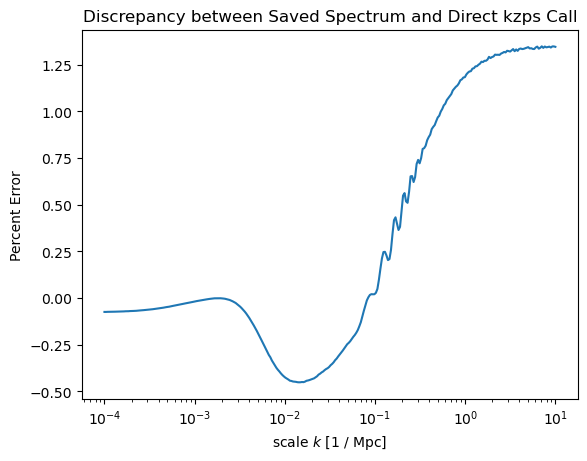

In [22]:
plt.plot(standard_k, (pci - pred_emulator) / pred_emulator * 100)
plt.xscale('log')
plt.title("Discrepancy between Saved Spectrum and Direct kzps Call")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

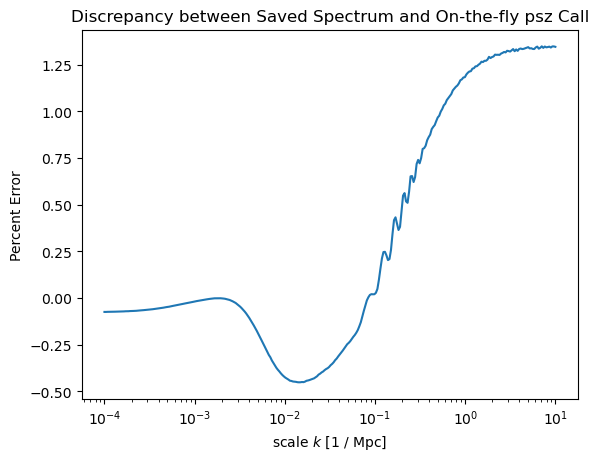

In [23]:
plt.plot(standard_k, (g_pspec - pred_emulator) / pred_emulator * 100)
plt.xscale('log')
plt.title("Discrepancy between Saved Spectrum and On-the-fly psz Call")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

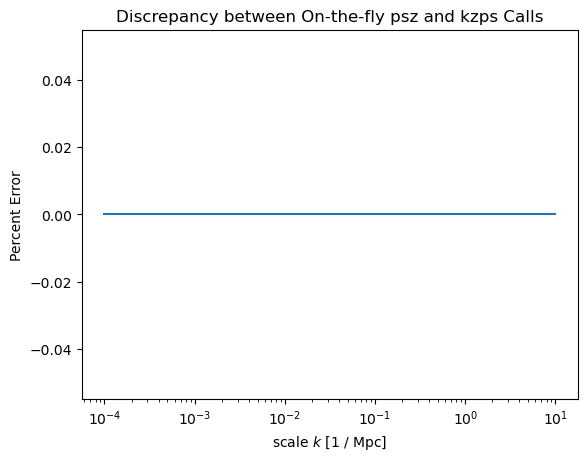

In [24]:
plt.plot(standard_k, (pci - g_pspec) / pci * 100)
plt.xscale('log')
plt.title("Discrepancy between On-the-fly psz and kzps Calls")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

This most recent plot is weak enough that we're happy. But why do we see differences in the previous plots? Is this a reproduceable discrepancy?

In [25]:
resample, bestz = ged.fill_hypercube(hc, standard_k, massive_neutrinos=True,
    cell_range=range(1))
resample = resample[0]

We had to move h to 0.57
0 complete


NameError: name 'redshifts_used' is not defined

In [ ]:
plt.plot(standard_k,
    (resample - pred_emulator) / pred_emulator * 100)
plt.xscale('log')